In [1]:
import numpy as np
import pandas as pd 
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

## Data Cleaning 

In [2]:
df = pd.read_csv('wiki_data.csv')
df=df[df.columns[1:]]
nan_values = df[df.columns[:26]].isna().sum().sort_values()
columns_keeping = nan_values[nan_values<6000].index.tolist()
df = df[columns_keeping +['rsp']]

df['Based on'] = df['Based on'].apply(lambda x: 0 if pd.isna(x) else 1)
df['rsp'] = df['rsp'].apply(lambda x: 0 if pd.isna(x) else 1)

In [3]:
for col in df.columns[1:].drop('Genres'):
    try:
        df[col] = df[col].str[3:-3]
    except:
        print(col)
        continue
        

Based on
rsp


In [4]:
df['Running time'] = df['Running time'].str.extract(r'(\d+)')
df['Running time'] = pd.to_numeric(df['Running time'])

## making all these columns into list becasue they have mulitple names and will make creating dummy variables for each
## later in the cleaning process
df['Directed by'] = df['Directed by'].str.split(',')
df['Starring'] = df['Starring'].str.split(',')
df['Produced by'] = df['Produced by'].str.split(',')
df['Screenplay by'] = df['Screenplay by'].str.split(',')
df['Edited by'] = df['Edited by'].str.split(',')
df['Cinematography'] = df['Cinematography'].str.split(',')
df['Written by'] = df['Written by'].str.split(',')
df['Music by'] = df['Music by'].str.split(',')
df['Productioncompanies '] = df['Productioncompanies '].str.split(',')
df['Distributed by'] = df['Distributed by'].str.split(',')
df['Productioncompany '] = df['Productioncompany '].str.split(',')

In [5]:
df['Release date'] = df['Release date'].str.split('(') 
df['Release date length'] = df['Release date'].apply(lambda x:len(x) if type(x) == list else x)
df['Release date'] =  df['Release date'][df['Release date length']!=10]

In [6]:
 def clean_release(row):
        if type(row)==list:
            if len(row)==1:
                return row[0]
            else:
                return row[1][:-1]
        else:
            return row
            
df['Release date']=df['Release date'].apply(clean_release).str.split(')').str[0]

In [7]:
def fix_dates (row):
    if pd.isna(row):
        return row
    else:
        try : 
            return datetime.strptime(row, "%Y-%m-%d")
        except:
            try:
                return datetime.strptime(row, "%B %d, %Y")
            except:
                return row
    

df['Release date'] = df['Release date'].apply(fix_dates)
df['Release date'] = df['Release date'].apply(lambda x: x if type(x) == datetime else np.nan)

In [8]:
import re 
df = df[df['Box office'].str.contains('$', na=False, regex=False)]  # remove any non dollar currency
df =df[~df['Box office'].str.contains('admission',na=False,regex=False)]#removes the 5 rows with admission in the box office col

def clean_box(row):
    box = row[1:]
    box =box.replace('$','')
    box = re.split(" |\(|\[", box)
    box = box[0].split('\\')[0]
    
    if bool(re.match(r".*million.*", row)):
        try: return float(box)*1000000
        except: return np.nan
    elif bool(re.match(r".*billion.*", row)):
        try: return float(box)*1000000000
        except: return np.nan  
        
    else: 
        try: return float(box.replace(',',''))
        except: return np.nan
    
    

df['Box office'] = df['Box office'].apply(clean_box)

In [9]:
df['million'] = df['Budget'].str.contains('millio',na=False,regex=False)
df['Budget']= df['Budget'].apply(lambda x: x if '$' in str(x) else 'Unknown')
df['Budget'] = df['Budget'].str[1:].apply(lambda x: re.split(' |\[', str(x))).str[0].str.replace(',','').str.split('\\').str[0]

def clean_budget(x):
    if x == 'Unknown':
        return np.nan
    if '–' in x:
        try: return (float(x.replace(',','').split('–')[0])+float(x.replace(',','').split('–')[1]))/2
        except: return np.nan
    else:
        try: return float(x)
        except: return np.nan


df['Budget'] = df['Budget'].apply(clean_budget)

In [10]:
def million(x):
    budget = x['Budget']
    if x['million'] == True:
        return budget*1000000
    else:
        return budget
df['Budget'] = df.apply(million,axis=1)
df = df.drop(columns=['Release date length','million'])
budget_drop = df[df['Budget']>500000000].index
df = df.drop(index=budget_drop)

In [11]:
def clean_names(row):
    row_list = []
    if type(row) == list:
        for word in row:
            word = word.replace("'",'')
            word = word.replace('"','')
            word = word.strip()
            if ']' in word:
                word = word[:-3]
            if len(word) <40:
                row_list.append(word)
        return row_list
    else: return np.nan
    
df['Starring'] = df['Starring'].apply(clean_names)
df['Produced by'] = df['Produced by'].apply(clean_names)
df['Edited by'] = df['Edited by'].apply(clean_names)
df['Cinematography'] = df['Cinematography'].apply(clean_names)
df['Directed by'] = df['Directed by'].apply(clean_names)
df['Written by'] = df['Written by'].apply(clean_names)
df['Productioncompanies '] = df['Productioncompanies '].apply(clean_names)
df['Music by'] = df['Music by'].apply(clean_names)
df['Screenplay by'] = df['Screenplay by'].apply(clean_names)
df['Distributed by'] = df['Distributed by'].apply(clean_names)
df['Productioncompany '] = df['Productioncompany '].apply(clean_names)

In [12]:
def strip_genres(row):
    if type(row) == list:
        return [x.strip().lower() for x in row]
    else:
        return np.nan
df['Genres']= df['Genres'].apply(lambda x: x if len(x)>2 else np.nan).str[1:-1]
df['Genres']= df['Genres'].str.replace("'",'').str.replace('film','').str.split(',')
df['Genres'] = df['Genres'].apply(strip_genres)

### Merge productioncompanies and productioncompany columns 

In [13]:
def production(x):
    comp = x['Productioncompany ']
    comps = x ['Productioncompanies ']
    if type(comp) == list and type(comps) != list:
        return comp
    elif type(comps) == list and type(comp) != list:
        return comps
    else:
        return comp+comps
    
df['Production companies']= df.apply(production, axis =1)
df['Production companies'] = df['Production companies'].apply(clean_names)
df = df.drop(columns = ['Productioncompanies ', 'Productioncompany '])

### Feature Engineering: Category reduction
- any date point that does not appear more than a certain threshhold will be lumped into the the 'other catrogory'
- due due varying amounts of granularity within the columns, the threshold will vary by column and will be tested experimentally 
---
- I am making a helper function that will count the items in the columns with list objects
- Going to test with threshold 1  

**finish explaining**

In [14]:
df['Country']=df['Country'].str.split('[').str[0].apply(lambda x:'other' if 'United States' not in str(x) else 'United States')
df['Language'] = df['Language'].str.split('[').str[0]
lang_counts = df['Language'].value_counts()
drop_langs = lang_counts[lang_counts<6].index
df['Language']= df['Language'].apply(lambda x: 'other' if x in drop_langs else x)

In [15]:
def list_counts(col,df):
    names = {}
    for i in df[col]:
        if type(i) == list:
            for j in i:
                if j not in names:
                    names[j] = 1
                else:
                    names[j] +=1
    count_df = pd.DataFrame.from_dict(names, orient='index', columns = ['Count'])
    count_df = count_df.sort_values(by='Count', ascending=False)
    return count_df

upper = list_counts('Genres',df)[list_counts('Genres',df)>=16]
upper.dropna(inplace=True)
keep_genres = upper.index


In [16]:
def drop_genres(row):
    if type(row) == list:
        genres = []
        for i in row:
            if i in keep_genres:
                genres.append(i)
            else:
                genres.append('other')
        return genres
    else:
        return np.nan
    
df['Genres']=df['Genres'].apply(drop_genres)

### Dummy variables for list objects in rows

In [17]:
# df = pd.read_csv('cleaned_data.csv')
# df['Release date']=pd.to_datetime(df['Release date'])
df = df.reset_index().drop(columns='index')

def make_dummies(df,col):
    
    dummy_df = df.copy()
    mlb = MultiLabelBinarizer()
    starring_nan = dummy_df[dummy_df[col].isna()].drop(columns=col)
    dummy_df = dummy_df[~dummy_df[col].isna()]

    dummy_df = dummy_df.join(pd.DataFrame(mlb.fit_transform(dummy_df.pop(col)),
                              columns=mlb.classes_,
                              index=dummy_df.index))

    combined = pd.concat([dummy_df, starring_nan], axis=0)
    dummies = combined.iloc[:,df.shape[1]-1:].fillna(0)
    
#     new = combined.iloc[:,:df.shape[1] -1]
#     new_df = pd.concat([new, dummies],axis=1)
    
    return dummies

In [18]:
# cols = df.select_dtypes('object').columns.drop(['Language','Country','Title'])
# old_df = df.copy()
# for col in cols:
#     x = make_dummies(old_df, col)
#     df = pd.concat([df,x], axis = 1)

In [19]:
cols = df.select_dtypes('object').columns.drop(['Language','Country','Title'])
old_df = df.copy()
for col in cols:
    x = make_dummies(old_df, col)
    x.columns = [col+'_'+ i for i in x.columns]
    df = pd.concat([df,x], axis = 1)

In [20]:
df_out = df.drop(columns=cols)
df_out.head()

,Title,Running time,Release date,Language,Box office,Country,Budget,Based on,rsp,Genres_3d,...,Production companies_de Passe Entertainment,Production companies_di Bonaventura Pictures,Production companies_eOne,Production companies_iDeal Partners,Production companies_inc.,Production companies_inc.Leeds / Ben-Ami Productions,Production companies_nWave Pictures,Production companies_uFilm,Production companies_uFund,Production companies_uMedia
0,The Adventures of Ford Fairlane,102.0,1990-07-11,English,21400000.0,United States,20000000.0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"After Dark, My Sweet",114.0,1990-05-17,English,2700000.0,United States,6000000.0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Air America,113.0,1990-08-10,English,57700000.0,United States,32500000.0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alice,106.0,1990-12-25,English,7331647.0,United States,12000000.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Almost an Angel,95.0,1990-12-19,English,6939946.0,United States,25000000.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_out.shape

(5903, 32695)

### Feature engineering: 
- Extracting day, month, year, day of the week, is weekend from  Release date column

In [22]:
df_out['Year'] = df_out['Release date'].dt.year
df_out['Month'] = df_out['Release date'].dt.month
df_out['Day'] = df_out['Release date'].dt.day
df_out['Day of week'] = df_out['Release date'].apply(lambda x: x.weekday())
df_out['is_weekend'] = df_out['Day of week'].apply(lambda x: 1 if x>=4 else 0)


df_out = df_out[df_out['Year']>=1990]    # removing any movies that are before 1990
df_out = df_out[df_out['Budget'] != 0] # removes two 0 budget values. Probably due to some mistake will parsing
# df_out['ROI'] = df_out['Box office']/df_out['Budget']

## Data Exploration
- going to seperate the into training and test data. I am only going to perform the data analysis training set to reduce date snooping bias

### 1) Numeric Data 
- histograms 
- grpahs
- corrplots 


In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [24]:
df_out.iloc[:,:9].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5702 entries, 0 to 5902
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Title         5702 non-null   object        
 1   Running time  5675 non-null   float64       
 2   Release date  5702 non-null   datetime64[ns]
 3   Language      5212 non-null   object        
 4   Box office    5636 non-null   float64       
 5   Country       5702 non-null   object        
 6   Budget        4612 non-null   float64       
 7   Based on      5702 non-null   int64         
 8   rsp           5702 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 445.5+ KB


In [25]:
df_out.iloc[:,:9].isna().sum()

Title              0
Running time      27
Release date       0
Language         490
Box office        66
Country            0
Budget          1090
Based on           0
rsp                0
dtype: int64

In [26]:
def split_train_test(data, test_ratio):
    np.random.seed(0)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_df, test_df = split_train_test(df_out, 0.2)

# oreiller machine learning book

In [27]:
numeric_cols = ['Running time', 'Box office', 'Budget']
df_num = train_df[numeric_cols]
df_num.describe()

,Running time,Box office,Budget
count,4537.000000,4.510000e+03,3.689000e+03
mean,106.496584,9.338194e+07,3.950076e+07
std,17.877240,1.807687e+08,4.485632e+07
min,50.000000,4.770000e+01,2.183200e+02
25%,94.000000,5.951009e+06,1.200000e+07
50%,103.000000,2.940698e+07,2.500000e+07
75%,116.000000,9.820000e+07,5.000000e+07
max,257.000000,2.811000e+09,4.696000e+08


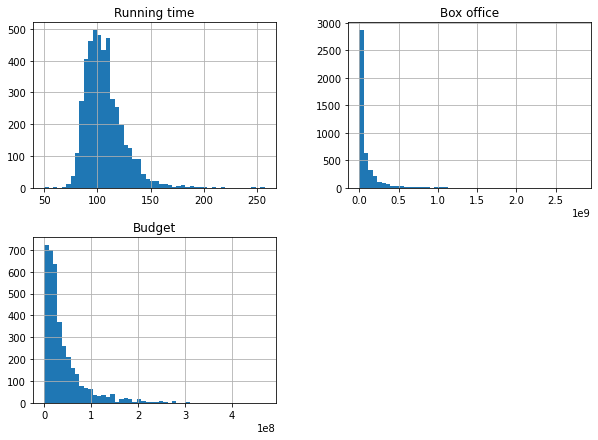

In [28]:
df_num.hist(bins=50, figsize=(10,7))
plt.show()

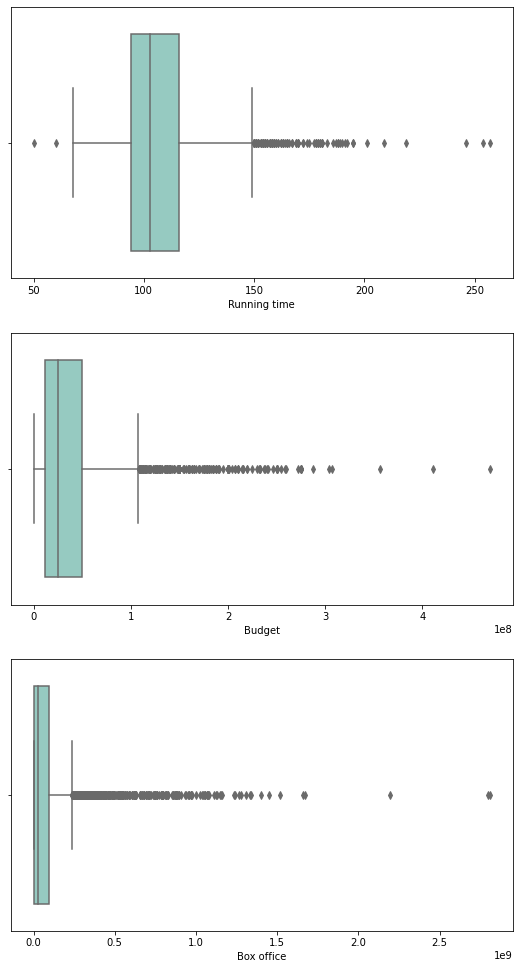

In [29]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(9,17))
sns.boxplot(x='Running time', data=df_num, palette='Set3', ax=axes[0])
sns.boxplot(x='Budget', data=df_num, palette='Set3', ax=axes[1])
sns.boxplot(x='Box office', data=df_num, palette='Set3', ax=axes[2])
plt.show()

- Running time has the least amount of outliers and the most normal distribution 
- Box office and Budget distributions are not normal and contain a imbalance amount of outliers 
    - consider using a logarithmic scaling or outlier removal

### Scatter plots and Correlations 

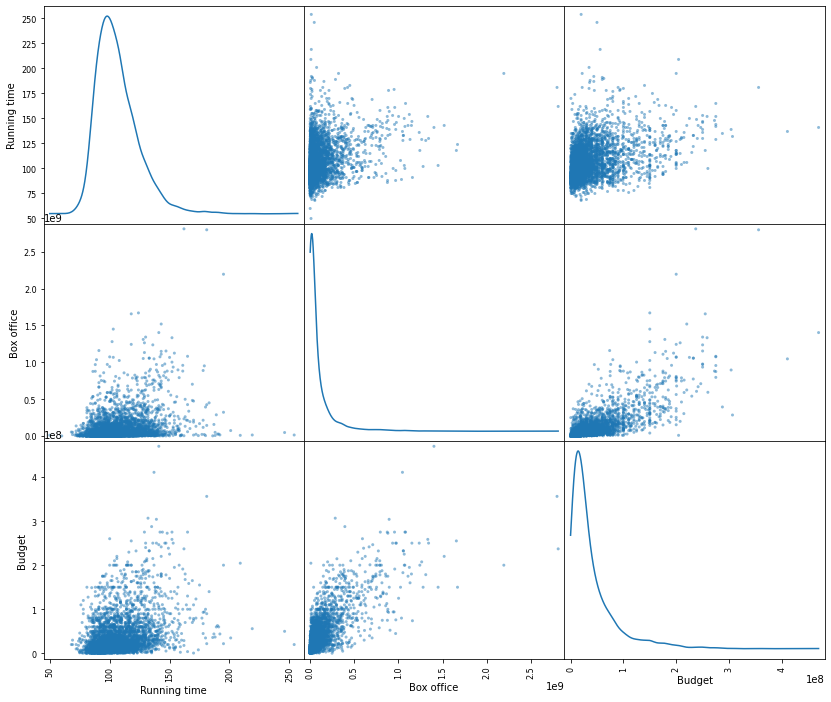

In [30]:
from sklearn.preprocessing import MinMaxScaler
pd.plotting.scatter_matrix(df_num,diagonal='kde', figsize=(14,12))
plt.show()

              Running time  Box office    Budget
Running time      1.000000    0.310174  0.347245
Box office        0.310174    1.000000  0.745458
Budget            0.347245    0.745458  1.000000


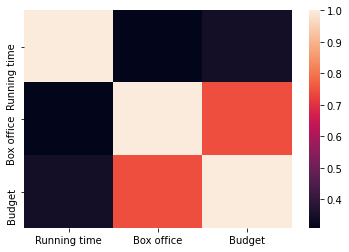

In [31]:
print(df_num.corr())
sns.heatmap(df_num.corr())
plt.show()

### Observations
- budget has the highest correlation to box office sales which is logical. Compnaies that invest more money into a movie expect to make more money. 
- Movies have higher budgets for good reason. Great starting cast and crew cost more than a relatively unknown cast and/or crew. Expensive set pieces, CGI, special effects, time filming are all factors that affect budget.
- Another interesting target variable could be return on investment which would be more usefull to production companies with smaller budgets 


## Categorical Data
- bar plots 
- pivot tables 
---
### Counts

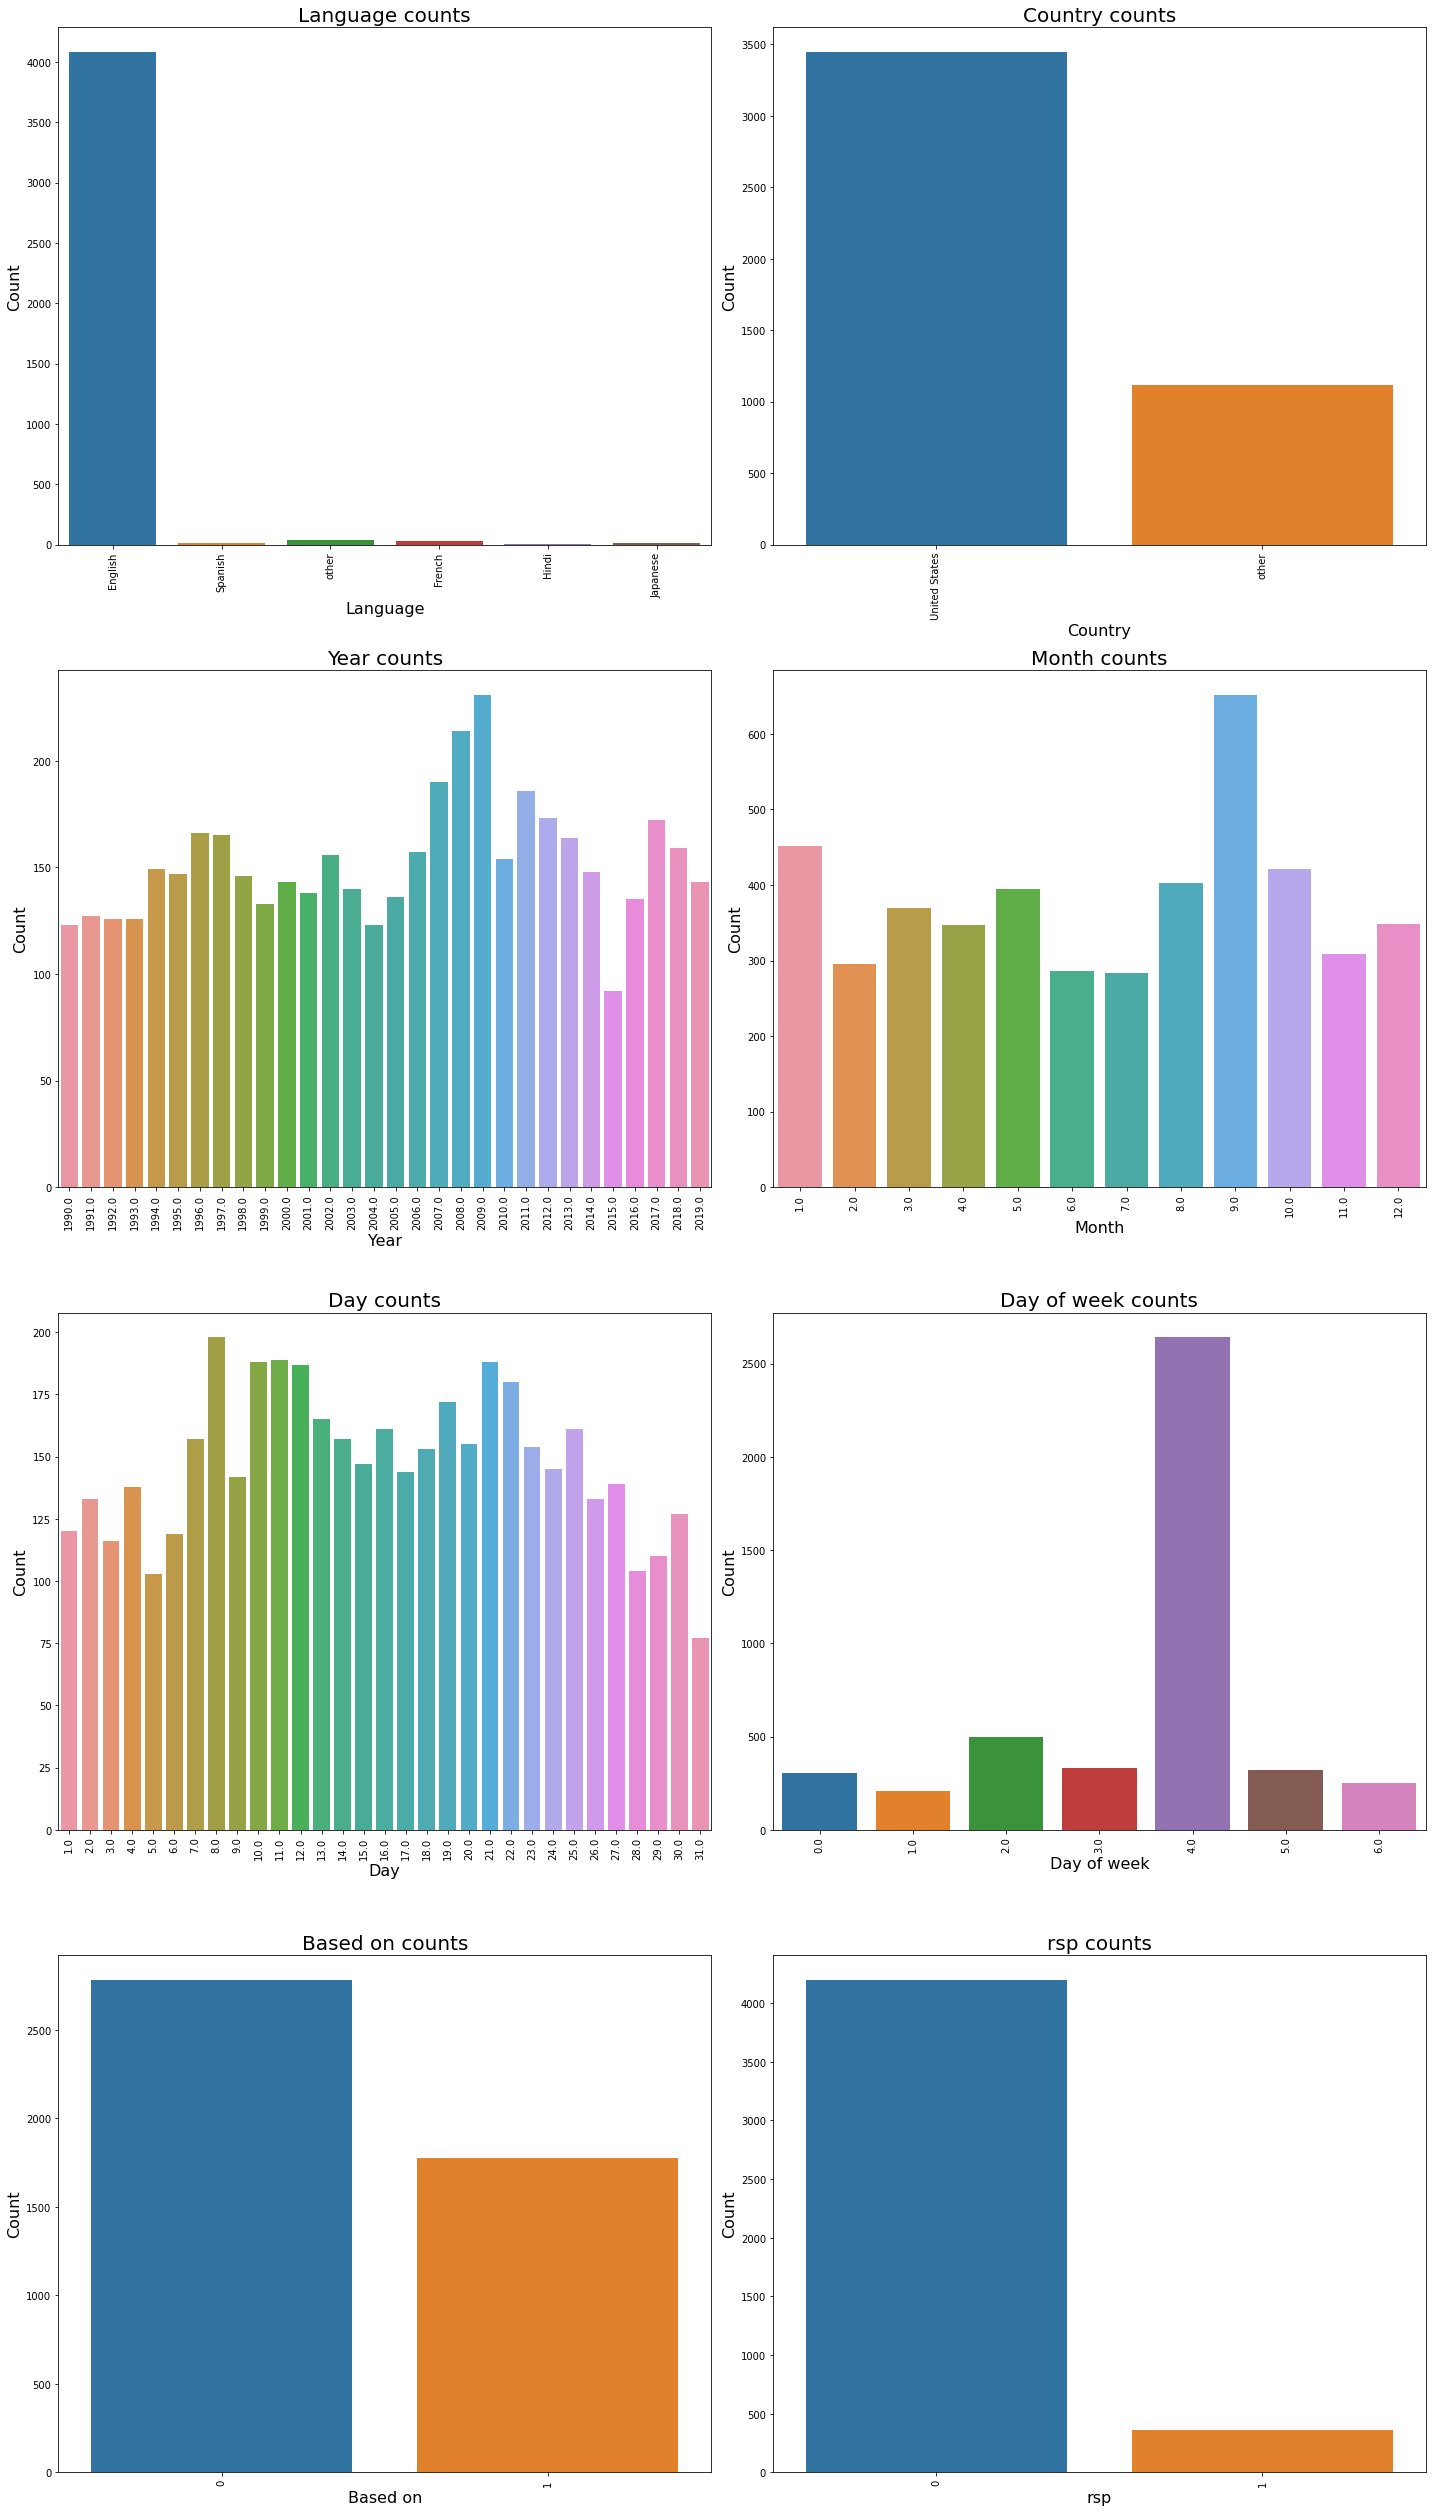

In [32]:
cats = ['Language','Country','Year','Month','Day','Day of week','Based on', 'rsp']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize = (20,35))

for i, ax in enumerate(axes.flatten()):
    sns.countplot(train_df[cats[i]], ax = ax )
    ax.set_title(cats[i] + ' counts', fontsize=20)
    ax.set_xlabel(cats[i],fontsize=16)
    ax.set_ylabel('Count',fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

### Observations:
- 4 meaning Friday has the most amount of movies release
- September has the most amount of movies released out of any months 
- mostly all movies are in english
- movies per year seem to be consistent 
---
### Means

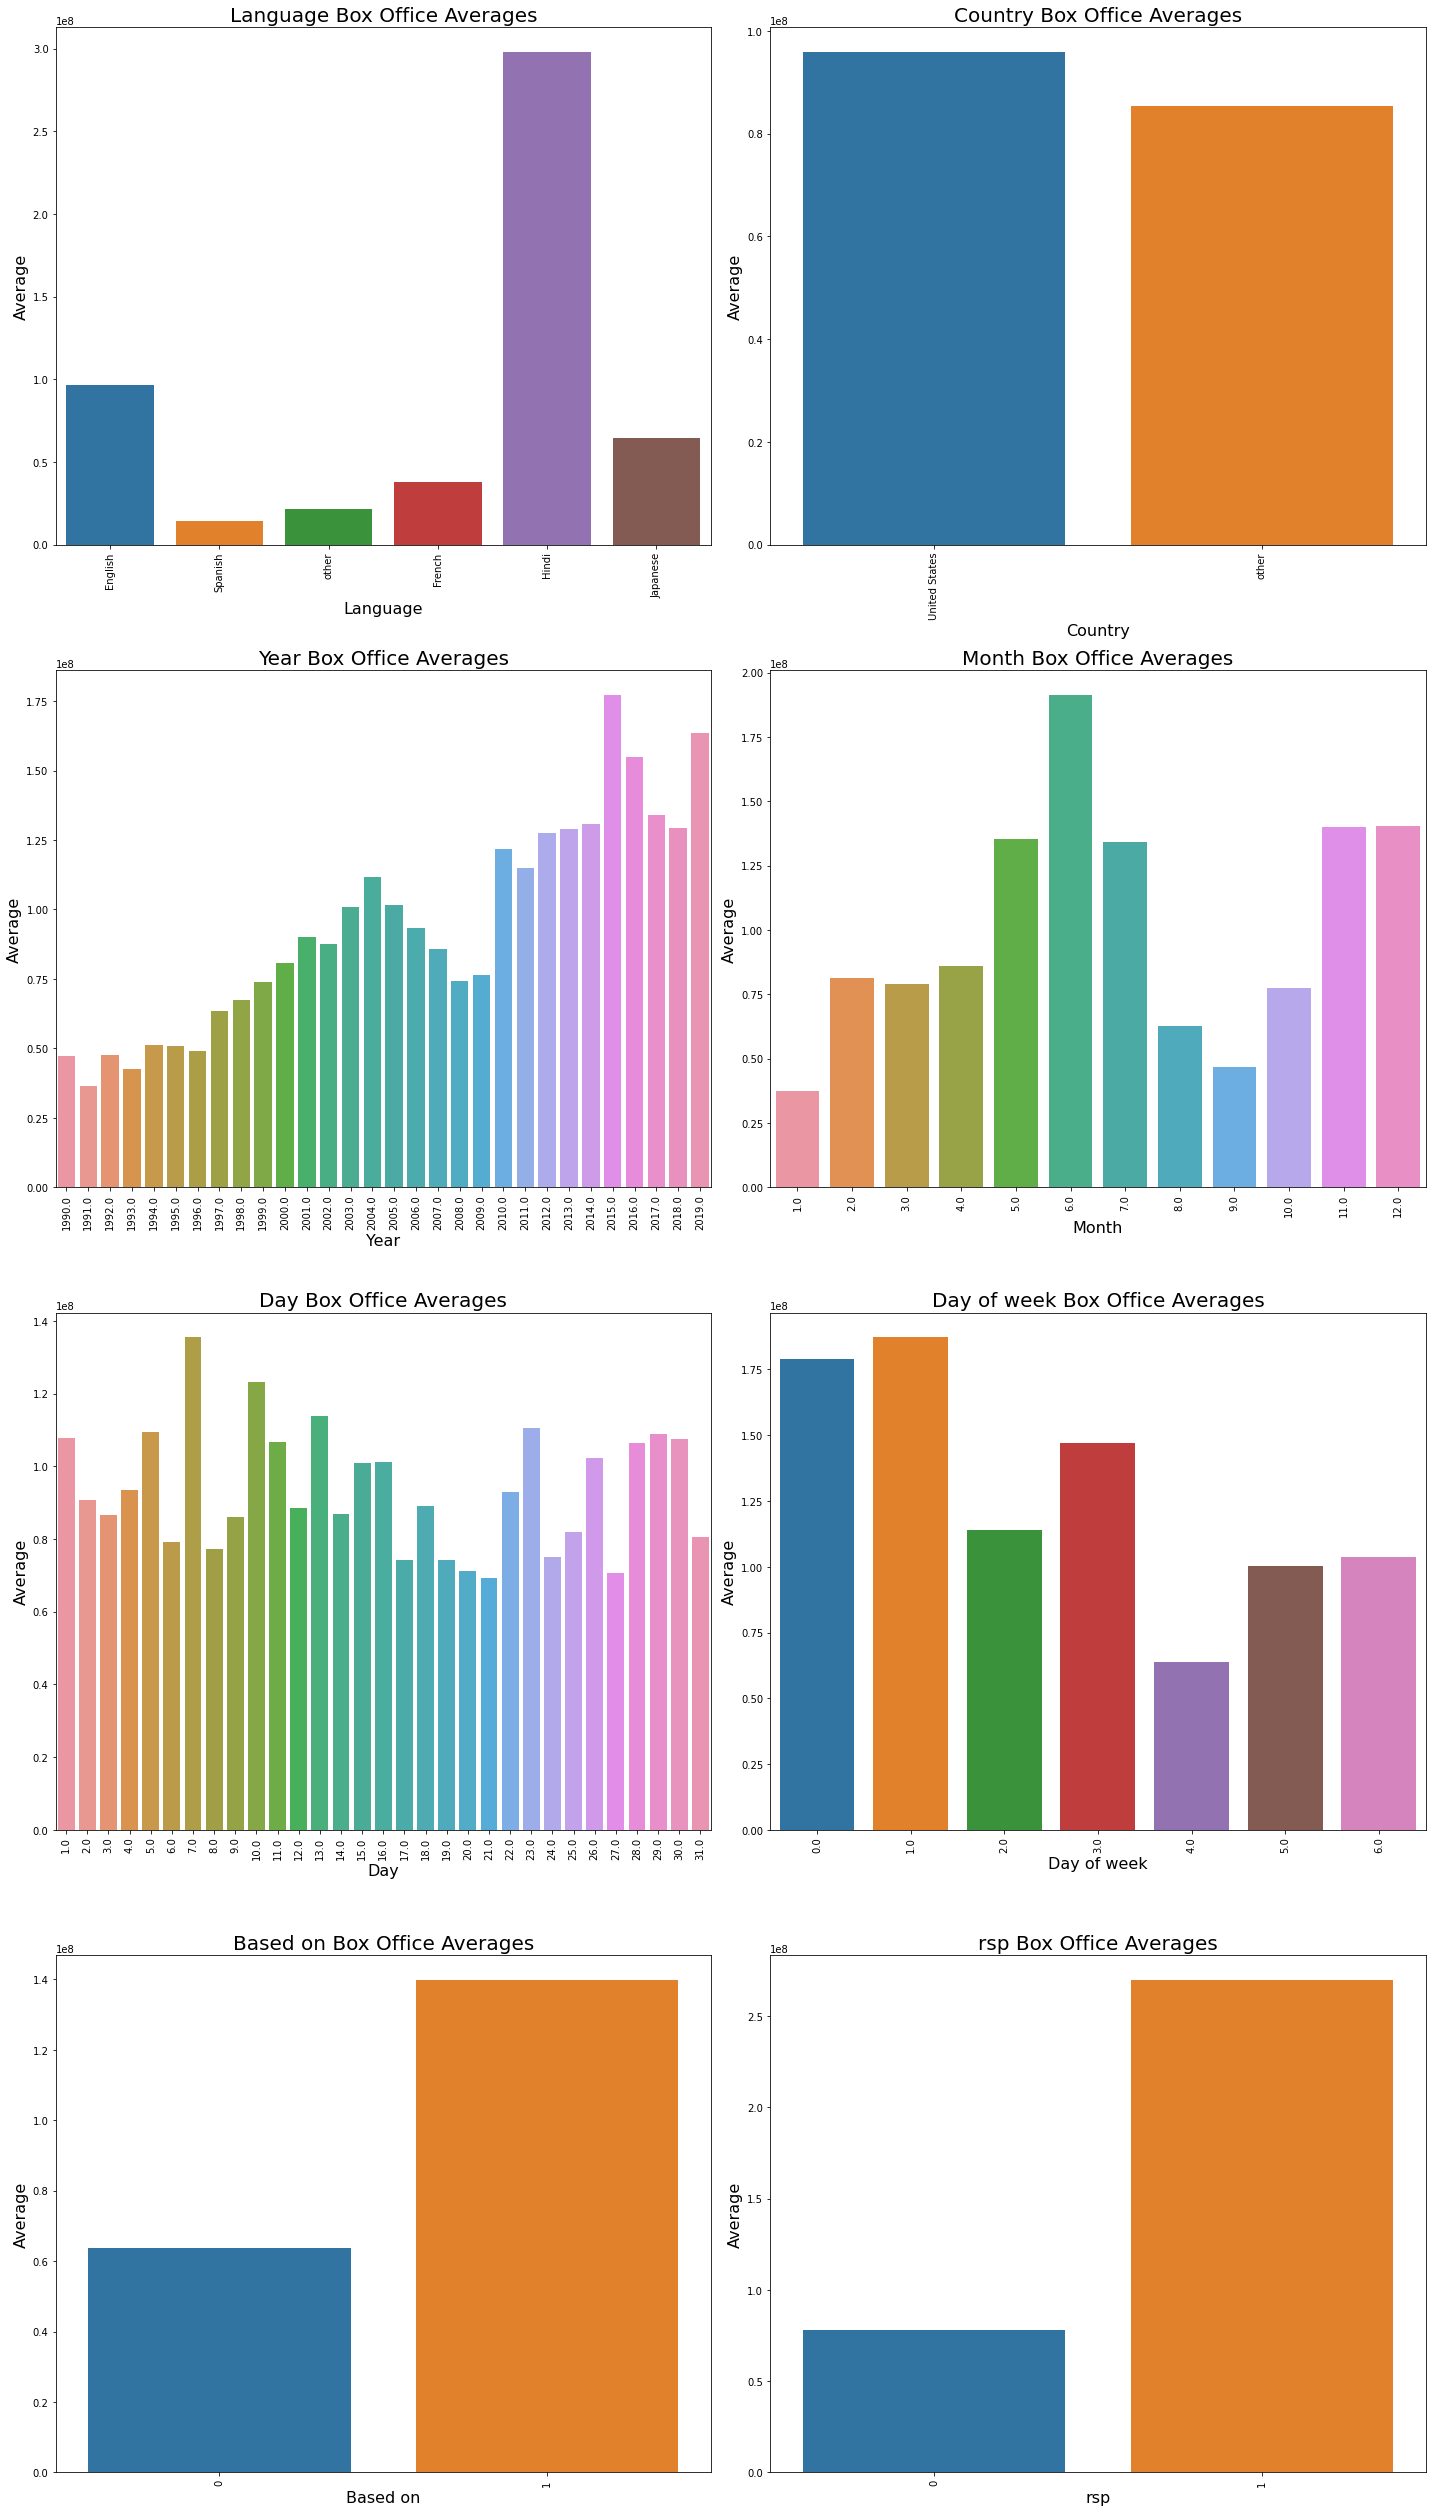

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize = (20,35))

for i, ax in enumerate(axes.flatten()):
    sns.barplot(x=cats[i],y='Box office', data = train_df, ci=None, ax=ax)
    ax.set_title(cats[i] + ' Box Office Averages', fontsize=20)
    ax.set_xlabel(cats[i],fontsize=16)
    ax.set_ylabel('Average',fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

### Observations 
- Hindi had the movies witht he highest box office. India is a country with a large population.
- Even though Friday has the most releases it has the lowest average box office which makes sense becasue of all the competetion. 
- Movies based on a book or a true story have a higher box office 
- June hase the highest box office 
- The year chart shoes movies with box office sales that are increasing which is most likely attributed to inflation.
- The two bar charts how the closely budget and box office are 

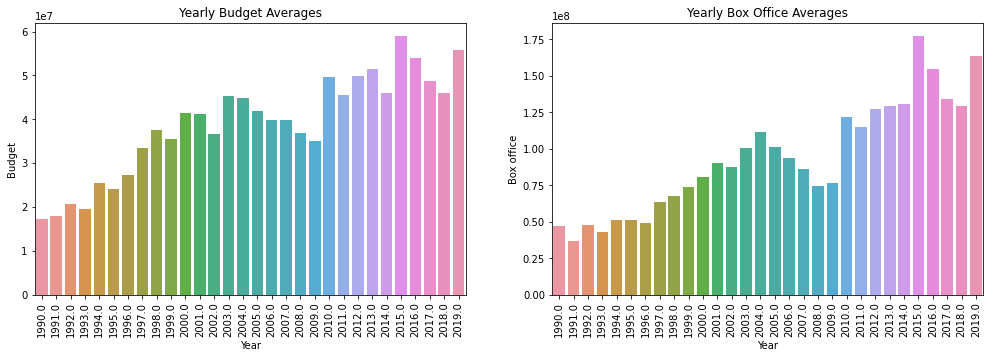

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,5)) 
sns.barplot(train_df['Year'],train_df['Budget'],ax=axes[0], ci=None)
axes[0].set_title('Yearly Budget Averages')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.barplot(train_df['Year'],train_df['Box office'],ax=axes[1], ci=None)
axes[1].set_title('Yearly Box Office Averages')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
plt.show()

Before we analzye the other columns I am going to clean the data a little bit more. 

In [35]:
roles = df.select_dtypes('object').columns.drop(['Language','Country','Title'])

In [36]:
def make_bar(role, feature):   
    top_ = [role+'_'+ i for i in list_counts(role,old_df)[:15].index]
    means = [train_df[train_df[i]==1][feature].mean() for i in top_]
    xlabels = list_counts(role,old_df)[:15].index
    
    fig = sns.barplot(x=xlabels,y= means, data = train_df)
    plt.title(role + ' Box office Averages')
    fig.set_xticklabels(fig.get_xticklabels(), rotation=90)
    plt.show()
    
    
for role in roles:
    make_bar(role, feature)

NameError: name 'feature' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize = (24,30))
feature='Box office'


for j, ax in enumerate(axes.flatten()):
    
    if j<11:
        top_ = [roles[j]+'_'+ i for i in list_counts(roles[j],old_df)[:15].index]
        means = [train_df[train_df[i]==1][feature].mean() for i in top_]
        xlabels = list_counts(roles[j],old_df)[:15].index

        sns.barplot(x=xlabels,y= means, data = train_df, ax =ax, ci=None)
        ax.set_title(roles[j] + ' Box Office Averages', fontsize=20)
        ax.set_xlabel(roles[j],fontsize=16)
        ax.set_ylabel('Average',fontsize=16)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.delaxes(axes[3,2])
plt.tight_layout()
plt.show()

### Observations
- Disney an Speilberg had noticably higher box office than their competitiors 